# Mitigação de erros

Tutorial disponível em: https://learn.qiskit.org/course/quantum-hardware/measurement-error-mitigation 

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
import numpy as np
import scipy.linalg as la
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram 

shots = 10000

Para entender melhor sobre os ruídos, vamos primeiro modelar um sistema onde o ruído se dá na medição de um qubit com uma probabilidade p. Como passado como parâmetro, estaremos simulando um circuito com 1% de probabilidade de encontrar ruído.

In [2]:
def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [3]:
noise_model = get_noise(0.01)

Aqui fazemos finalmente a simulação. inicializando um circuito de 2 qubits nos estados |00>, |01>, |10> e |11> e acrescentando o erro, percebemos que na maioria das vezes o resultado está correto e ainda é possível interpretar corretamente os dados.

In [5]:
list_res = []
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    #vamos salvar a execução em uma variavel para usar mais tarde
    res = execute(qc, Aer.get_backend('qasm_simulator'),
                  noise_model=noise_model,shots=shots).result().get_counts()
    print(state +' se tornou:', res)
    list_res.append(res)

00 se tornou: {'00': 9818, '01': 88, '10': 93, '11': 1}
01 se tornou: {'01': 9816, '00': 92, '11': 91, '10': 1}
10 se tornou: {'10': 9829, '11': 78, '00': 89, '01': 4}
11 se tornou: {'11': 9781, '01': 108, '10': 110, '00': 1}


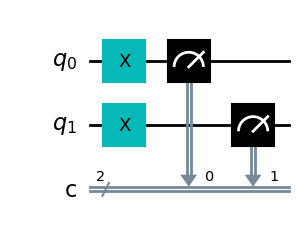

In [6]:
qc.draw('mpl')

Mas em um circuito um pouco diferente, que utiliza uma superposição e por isso o resultado deveria ser ou |00> ou |11>, o erro começa a interferir na possibilidade de intterpretação dos resultados, como pode ser visto a seguir:

In [7]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),
              noise_model=noise_model,shots=10000).result().get_counts())

{'11': 4959, '00': 4837, '10': 99, '01': 105}


## Mitigando erros com Algebra Linear

Vamos primeiro construir uma matriz com os resultados normalizados que obtivemos para todos os valores na preparação de estados. Pode ser necessário adicionar manualmente um valor zero na lista se algum estado não tiver sido medido. Com essa matriz é possível descobrir como serão as medidas de erro, ao realizar o produto interno com o vetor com as probabilidades ideais (lembrando sempre de manter a ordenação "|00>, |01>, |10>, |11>" durante os calculos). No calculo abaixo estamos calculando o erro para a operação de Hadammard:

In [8]:
#matriz com os resultados dos calculos
M = [ [list_res[0]['00'],list_res[0]['01'],list_res[0]['10'],list_res[0]['11']],
    [list_res[1]['00'],list_res[1]['01'],list_res[1]['10'],list_res[1]['11']],
    [list_res[2]['00'],list_res[2]['01'],list_res[2]['10'],list_res[2]['11']],
    [list_res[3]['00'],list_res[3]['01'],list_res[3]['10'],list_res[3]['11']] ]

#normalizando pelo numero de shots
for i in range (len(M)):
    M[i] = np.array(M[i])/shots

#a probabilidade ideal que gostariamos para uma operação de Hadammard
Cideal = [ [5000],
          [0],
          [0],
          [5000] ]

Cnoisy = np.dot(M, Cideal)
print('C_noisy =\n', Cnoisy)

C_noisy =
 [[4909.5]
 [  91.5]
 [  83.5]
 [4891. ]]


Este método acima é uma boa forma de estimar como serão os resultados, já que se compararmos ele apenas aproxima do que foi obtido experimentalmente. Agora para transformar dados ruidosos em dados ideiais, o que precisamos é do processo oporto, que podemos fazer utilizando a matriz inversa:

In [9]:
# invertendo a matriz
Minv = la.inv(M)
print(Minv)

#operando com o resultado da Hadammard com ruido
Cmitigated = np.dot(Minv, Cnoisy)

#transformando em inteiro (contagens)
for i in range(len(Cmitigated)):
    Cmitigated[i] = [int(j) for j in Cmitigated[i]]

print('C_mitigated =\n', Cmitigated)

[[ 1.01871030e+00 -9.12939873e-03 -9.63854609e-03  5.76496866e-05]
 [-9.54784830e-03  1.01893476e+00  9.27642631e-05 -9.47968013e-03]
 [-9.22120390e-03 -2.42744826e-04  1.01757555e+00 -8.11160229e-03]
 [ 1.04977993e-04 -1.12472266e-02 -1.14439925e-02  1.02258624e+00]]
C_mitigated =
 [[5000.]
 [   0.]
 [   0.]
 [5000.]]


## Mitigando erros no Qiskit

Vamos primeiro criar um circuito para cada elemento da nossa base:

In [10]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit', circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q17_0: ─░─┤M├───
        ░ └╥┘┌─┐
q17_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q17_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q17_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q17_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q17_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q17_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q17_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 



C:\Users\windows\AppData\Local\Temp\ipykernel_24556\4077162033.py:2: DeprecationWarning: The function ``qiskit.utils.mitigation.circuits.complete_meas_cal()`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')


Com o resultado da execução do circuito podemos criar uma matriz de calibração, como feita a seguir.  
Se executarmos os circuitos em um simulador, sem adicionar uma função de ruído, teremos como resultado a matriz identidade:

In [11]:
# executando sem ruido:

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()
#print(cal_results)

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


C:\Users\windows\AppData\Local\Temp\ipykernel_24556\2922083627.py:8: DeprecationWarning: The class ``qiskit.utils.mitigation.fitters.CompleteMeasFitter`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')


Já com adição de ruídos sobre os mesmos circuitos usados no exemplo anterior, temos uma matriz como a M que trabalhamos anteriormente. Podemos então diminuir os erros causados pelo ruído aplicando um filtro na medida 

In [12]:
noise_model = get_noise(0.1)

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.811 0.089 0.091 0.01 ]
 [0.092 0.802 0.013 0.095]
 [0.089 0.005 0.822 0.1  ]
 [0.008 0.104 0.074 0.795]]


C:\Users\windows\AppData\Local\Temp\ipykernel_24556\2753856379.py:7: DeprecationWarning: The class ``qiskit.utils.mitigation.fitters.CompleteMeasFitter`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')


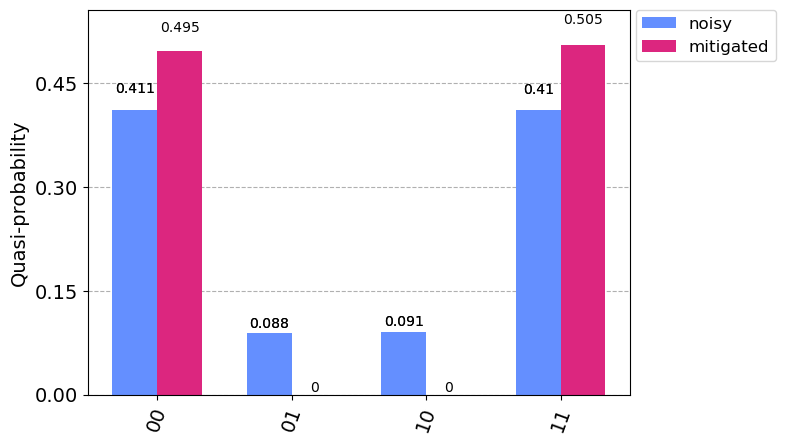

In [13]:
# executando para visualizar no estado de Bell
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
#print(noisy_counts)

# Adicionando um filtro
meas_filter = meas_fitter.filter

# Resultados com a mitigação de erros
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])